Course name: Natural Language Processing & Text Mining  
Course code: 472867-HS2024-0  
Project Task 2: Named Entity Recognition 

Autumn Semester 2024-2025  
Master in Artificial Intelligence for Medicine  
Universität Bern  

*Group Members: Rachel Robles (23-125-966), Corina Hüni (19-819-903), Chanae Smith (23-107-915)*


In [1]:
import json
import random
import re
from collections import Counter
import subprocess
import os
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from datasets import load_dataset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import filter_spans, minibatch, compounding
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline



# **PART A - Dataset Exploration**  
---

_Investigate which standard and potential new NER types are most prominent in your data set (i.e., manual data inspection)._

In [2]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")
train_data = dataset['train']

In [3]:
def inspect_data(data, num_samples=5):
    # Print out the full structure of dataset
    for i, item in enumerate(data[:num_samples], 1):
        print(f"Features {i}: {item}\n")

    # Print out the structure and content of the first few data entries
    for i in range(num_samples):
        sample = data[i]
        print(f"Sample {i+1}: {sample}\n")

# Run the inspection of data
inspect_data(train_data)

Features 1: text

Features 2: inputs

Features 3: prediction

Features 4: prediction_agent

Features 5: annotation

Features 6: annotation_agent

Features 7: multi_label

Features 8: explanation

Features 9: id

Features 10: metadata

Features 11: status

Features 12: event_timestamp

Features 13: metrics

Sample 1: {'text': 'PREOPERATIVE DIAGNOSIS:,  Iron deficiency anemia.,POSTOPERATIVE DIAGNOSIS:,  Diverticulosis.,PROCEDURE:,  Colonoscopy.,MEDICATIONS: , MAC.,PROCEDURE: , The Olympus pediatric variable colonoscope was introduced into the rectum and advanced carefully through the colon to the cecum identified by the ileocecal valve and the appendiceal orifice.  Preparation was good, although there was some residual material in the cecum that was difficult to clear completely.  The mucosa was normal throughout the colon.  No polyps or other lesions were identified, and no blood was noted.  Some diverticula were seen of the sigmoid colon with no luminal narrowing or evidence of inflamm

### *Findings*

Standard NER types that are prominent in the data include:
- Person: Names of patients, doctors, etc.
- Date and Time: Procedure dates, admission dates, historical medical information, etc.
- Locations: Cities, country names, etc
- Organizations: Hospitals, clinics, or medical departments (e.g., radiology).
- Quantification: Cardinal numbers, percentages, and product-related information.

Potential new NER types prominent in the data include:
- Diagnosis: Medical conditions (e.g., anemia, carcinoma).
- Symptoms: Descriptions of patient symptoms (e.g., "back pain," "nocturia").
- Treatment: Prescriptions, procedures, or follow-ups (e.g., "colonoscopy," "high-fiber diet").
- Lab Values: Measurements and results (e.g., "ejection fraction," "hemoglobin levels")
- Anatomical Location: Specific body parts or anatomical locations.
- Medication: Names of drugs or pharmaceutical compounds prescribed or administered.
- Medical Equipment: Devices or instruments used in medical procedures or patient care.
- Genetic Markers: Specific genes or genetic variations relevant to patient diagnosis or treatment.
- Dosage Information: Details regarding the amount and frequency of medication administration.
- Hospital Department: Specific departments within a hospital, such as cardiology or oncology.
- Allergies: Documented patient allergies to medications, foods, or other substances.
- Clinical Tests: Specific diagnostic tests or assessments conducted on patients.

# **PART B - spaCy's Standard NER Classifier**  
---
_Apply the standard NER classifier of spaCy to your data._

In [4]:
# Initialize the spaCy model
nlp = spacy.load("en_core_web_sm")

In [5]:
# Function to extract entities from a text
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Process the dataset and save results
results = []
for example in train_data['text']:
    entities = extract_entities(example)
    results.append({'text': example, 'entities': entities})

In [6]:
# Save the results to a CSV
output_file = "spacy_ner_results.csv"
df = pd.DataFrame(results)
df.to_csv(output_file, index=False)

print(f"spaCy NER outputs saved to {output_file}")

spaCy NER outputs saved to spacy_ner_results.csv


# **PART C - Evaluation of NER Classifier**  
---
_Find out how to evaluate the quality of the NER classification and evaluate it automatically and manually with 100 randomly sampled entities._

## **C.1 - Qualitative Evaluation**

In [7]:
# Initialize a counter for NER labels
ner_counter = Counter()

# Dictionary to store up to 5 examples for each NER label
ner_examples = {}

# Process the results list
for result in results:
    for entity_text, entity_label in result['entities']:
        ner_counter[entity_label] += 1
        if entity_label not in ner_examples:
            ner_examples[entity_label] = []
        
        # Store up to 5 examples for each label
        if len(ner_examples[entity_label]) < 5:
            ner_examples[entity_label].append(entity_text)

In [8]:
# Print the summary of NER types and their counts
print("NER Types and Their Counts:")
for label, count in ner_counter.items():
    print(f"{label}: {count}")

NER Types and Their Counts:
ORG: 30895
NORP: 4010
PERSON: 19049
DATE: 19713
GPE: 9398
PERCENT: 3166
CARDINAL: 31112
WORK_OF_ART: 628
PRODUCT: 4946
QUANTITY: 7428
MONEY: 3663
TIME: 4156
ORDINAL: 3386
EVENT: 117
FAC: 745
LOC: 1304
LANGUAGE: 153
LAW: 417


In [9]:
# Print some results
for result in results[:3]: 
    print(f"Text: {result['text']}")
    print(f"Entities: {result['entities']}\n")

Text: PREOPERATIVE DIAGNOSIS:,  Iron deficiency anemia.,POSTOPERATIVE DIAGNOSIS:,  Diverticulosis.,PROCEDURE:,  Colonoscopy.,MEDICATIONS: , MAC.,PROCEDURE: , The Olympus pediatric variable colonoscope was introduced into the rectum and advanced carefully through the colon to the cecum identified by the ileocecal valve and the appendiceal orifice.  Preparation was good, although there was some residual material in the cecum that was difficult to clear completely.  The mucosa was normal throughout the colon.  No polyps or other lesions were identified, and no blood was noted.  Some diverticula were seen of the sigmoid colon with no luminal narrowing or evidence of inflammation.  A retroflex view of the anorectal junction showed no hemorrhoids.  The patient tolerated the procedure well and was sent to the recovery room.,FINAL DIAGNOSES:,1.  Diverticulosis in the sigmoid.,2.  Otherwise normal colonoscopy to the cecum.,RECOMMENDATIONS:,1.  Follow up with Dr. X as needed.,2.  Screening colon

In [10]:
# Print 5 examples for each NER type
print("\nExamples for Each NER Type:")
for label, examples in ner_examples.items():
    print(f"{label}: {examples}")


Examples for Each NER Type:
ORG: ['Olympus', 'DETAIL', 'LAD', 'RCA', 'LAD']
NORP: ['retroflex', '6-French', '6-French', 'x2.,3', 'x2.,3']
PERSON: ['X', 'Normal', 'Selective', 'LV gram.', 'Mynx']
DATE: ['2 years', '9', '85-year-old', '68-year-old', '2004']
GPE: ['anesthesia', 'LAD', 'Anesthesia', 'Macula', 'anesthesia']
PERCENT: ['2%', '50% to 60%', '40%', '50% to 60%', '40%']
CARDINAL: ['6', '6', '60%.,PLAN', 'L1', '20/20']
WORK_OF_ART: ['Post LV gram', 'Fahrenheit', 'DIAGNOSES,1', 'Lungs', 'Versed IV.,FINDINGS:']
PRODUCT: ['T11-12', 'G3 P 2', 'Munro', 'Accurus', 'T8']
QUANTITY: ['4.6mm', '360 degrees', 'approximately 0.5 cm', '2.6 cm', '10 mm']
MONEY: ['13).,L3', '#0 Vicryl', '2', '3', '3']
TIME: ['daytime', 'three hours', '15 minutes', "1 o'clock", "9 o'clock"]
ORDINAL: ['second', 'third', 'first', 'second', 'first']
EVENT: ['Depression', 'Hospital Day Surgery', 'Gram', 'Gram', 'Cup']
FAC: ['Charcot-Marie', 'Oriented x3', 'IV Nexium 40', 'Rocephin IV', 'Hospital']
LOC: ['Inpatient O

### *Findings*

- Qualitative analysis of the SpaCy NER classifier on the dataset reveals significant shortcomings in its performance. 
- The most common standard NER types were ORG (30,895 occurrences), CARDINAL (31,112 occurrences), and DATE (19,713 occurrences). 
- Rare NER types included EVENT (117 occurrences), LANGUAGE (153 occurrences), and LAW (417 occurrences). 
- Although the classifier correctly identified entities such as "50% to 60%" (PERCENT), and "2 years" (DATE), it misclassified entities way more often. For example, "retroflex" (NORP), "facet joints" (PERSON), and "T12-L1.,L1-2" (ORG) were incorrectly labeled. 
- Additionally, many tokens that were in fact NER types were not identified at all. 
- This suggests that the standard SpaCy model, trained on general-purpose data, is not well-suited for medical NER tasks, as most identified entities were mislabeled, and many relevant tokens were missed. 

## **C.2 - Automatic Evaluation**

### **C.2.1 - Data Subset**

In [11]:
# Extract the first 100 samples from the dataset
first_100_samples = dataset['train'].select(range(100))

In [12]:
# Initialize counters and lists
class_counter = Counter()
sentence_lengths = []
character_lengths = []

# Iterate over the first 100 samples
for sample in first_100_samples:
    # Access the 'prediction' field which contains the class labels
    predictions = sample.get('prediction', [])
    for prediction in predictions:
        label = prediction.get('label')
        if label:
            class_counter[label] += 1

    # Access the 'text' field
    text = sample.get('text', '')
    if text:
        # Count sentences using regex to split on sentence-ending punctuation
        sentences = re.split(r'[.!?]', text)
        # Filter out empty strings after split
        sentences = [s for s in sentences if s.strip()]
        sentence_lengths.append(len(sentences))

        # Count characters
        character_lengths.append(len(text))

# Calculate statistics
num_samples = len(first_100_samples)
num_unique_classes = len(class_counter)
samples_per_class = dict(class_counter)
min_sentences = np.min(sentence_lengths) if sentence_lengths else 0
avg_sentences = np.mean(sentence_lengths) if sentence_lengths else 0
max_sentences = np.max(sentence_lengths) if sentence_lengths else 0
min_characters = np.min(character_lengths) if character_lengths else 0
avg_characters = np.mean(character_lengths) if character_lengths else 0
max_characters = np.max(character_lengths) if character_lengths else 0

# Print statistics
print(f"Number of samples: {num_samples}")
print(f"Number of unique classes: {num_unique_classes}")
print(f"Number of samples per class: {samples_per_class}")
print(f"Text length in sentences - Min: {min_sentences}, Avg: {avg_sentences:.2f}, Max: {max_sentences}")
print(f"Text length in characters - Min: {min_characters}, Avg: {avg_characters:.2f}, Max: {max_characters}")


Number of samples: 100
Number of unique classes: 28
Number of samples per class: {' Gastroenterology': 5, ' Surgery': 22, ' Radiology': 4, ' SOAP / Chart / Progress Notes': 2, ' Letters': 3, ' Lab Medicine - Pathology': 1, ' Consult - History and Phy.': 15, ' Podiatry': 1, ' General Medicine': 5, ' Psychiatry / Psychology': 2, ' Cardiovascular / Pulmonary': 6, ' Urology': 1, ' Ophthalmology': 1, ' Physical Medicine - Rehab': 2, ' Neurology': 5, ' Autopsy': 1, ' Orthopedic': 6, ' Hematology - Oncology': 1, ' Allergy / Immunology': 1, ' Pediatrics - Neonatal': 2, ' Dentistry': 2, ' Neurosurgery': 4, ' Pain Management': 2, ' Nephrology': 2, ' Emergency Room Reports': 1, ' Obstetrics / Gynecology': 1, ' Speech - Language': 1, ' Diets and Nutritions': 1}
Text length in sentences - Min: 1, Avg: 45.70, Max: 139
Text length in characters - Min: 12, Avg: 3203.55, Max: 9991


### **C.2.2 - Ground Truth (Manual Annotation)**

In [13]:
# Load the annotations from the JSON file
with open('annotations.json', 'r') as f:
    annotations_data = json.load(f)

# Format them 
annotations_gt = []
for annotation in annotations_data['annotations']:
    if annotation:
        text = annotation[0] 
        entities = []
        for start, end, label in annotation[1]['entities']:
            entity_text = text[start:end]  # Extract text using offsets
            entities.append((entity_text.strip(), label))
        annotations_gt.append({'text': text, 'entities': entities})


In [14]:
# Save the results to a CSV
output_file = "annotations_gt.csv"
df = pd.DataFrame(annotations_gt)
df.to_csv(output_file, index=False)

print(f"Formatted ground truth annotations saved to {output_file}")

Formatted ground truth annotations saved to annotations_gt.csv


In [15]:
# Explore characteristics of the annotations
# Initialize a counter for NER labels
annotation_counter = Counter()

# Dictionary to store up to 5 examples for each NER label
annotation_examples = {}

# Process the formatted annotations
for annotation in annotations_gt:
    for entity_text, entity_label in annotation['entities']:
        annotation_counter[entity_label] += 1
        if entity_label not in annotation_examples:
            annotation_examples[entity_label] = set()

        # Store unique examples for each label
        if len(annotation_examples[entity_label]) < 5:
            annotation_examples[entity_label].add(entity_text)

# Convert sets back to lists for printing
annotation_examples = {label: list(examples) for label, examples in annotation_examples.items()}


In [16]:
# Print the summary of NER types and their counts
print("NER Types and Their Counts in Annotations:")
for label, count in annotation_counter.items():
    print(f"{label}: {count}")


NER Types and Their Counts in Annotations:
MEDICAL DIAGNOSIS: 1312
MEDICAL PROCEDURE: 935
MEDICATION: 409
ANATOMICAL LOCATION: 1720
CARDINAL: 1413
PERSON: 63
DATE: 136
PERCENT: 73
SYMPTOM: 696
TIME: 377
LOC: 46


In [17]:
# Print some annotation results
print("\nSome Annotation Results:")
for annotation in annotations_gt[:3]:  # Show first 3 samples
    print(f"Text: {annotation['text']}")
    print(f"Entities: {annotation['entities']}\n")



Some Annotation Results:
Text:         "PREOPERATIVE DIAGNOSIS:,  Iron deficiency anemia.,POSTOPERATIVE DIAGNOSIS:,  Diverticulosis.,PROCEDURE:,  Colonoscopy.,MEDICATIONS: , MAC.,PROCEDURE: , The Olympus pediatric variable colonoscope was introduced into the rectum and advanced carefully through the colon to the cecum identified by the ileocecal valve and the appendiceal orifice.  Preparation was good, although there was some residual material in the cecum that was difficult to clear completely.  The mucosa was normal throughout the colon.  No polyps or other lesions were identified, and no blood was noted.  Some diverticula were seen of the sigmoid colon with no luminal narrowing or evidence of inflammation.  A retroflex view of the anorectal junction showed no hemorrhoids.  The patient tolerated the procedure well and was sent to the recovery room.,FINAL DIAGNOSES:,1.  Diverticulosis in the sigmoid.,2.  Otherwise normal colonoscopy to the cecum.,RECOMMENDATIONS:,1.  Follow up with D

In [18]:
# Print 5 examples for each NER type
print("\nExamples for Each NER Type in Annotations:")
for label, examples in annotation_examples.items():
    print(f"{label}: {examples}")



Examples for Each NER Type in Annotations:
MEDICAL DIAGNOSIS: ['Diverticulosis', 'polyps', 'diverticula', 'lesions', 'Iron deficiency anemia']
MEDICAL PROCEDURE: ['Selective coronary angiography', 'colonoscopy', 'Normal stress test', 'Left heart cath.', 'Colonoscopy']
MEDICATION: ['lidocaine', 'MAC.', 'Astramorph', 'alpha-blocker', 'Proscar']
ANATOMICAL LOCATION: ['appendiceal orifice', 'cecum', 'rectum', 'colon', 'ileocecal valve']
CARDINAL: ['1', '2', '3', '4', '5']
PERSON: ['Dr. X', 'XYZ', 'Mr. ABC', 'ABC', 'Dr. XYZ']
DATE: ['DOB:  MM/DD/YYYY', '2003', 'five years', '2 years', '2004']
PERCENT: ['40%', '60%', '2%', '85%', '50%']
SYMPTOM: ['irritative issues', 'irritative symptoms', 'frequency', 'nocturia', 'occasional daytime frequency']
TIME: ['three hours', 'daily', '15 minutes', '30 and 4/7th weeks', 'three months']
LOC: ['Terrace Independent Living Center', 'Department of Anesthesia', 'ABCD General Hospital', 'Terrace', "UTMB Hospitals VP's office"]


### **C.2.3 - spaCy NER on 100 samples**

In [19]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Apply spaCy NER to subsetted dataset
spacy_100_results = []
for example in first_100_samples['text']:
    entities = extract_entities(example)
    spacy_100_results.append({'text': example, 'entities': entities})

In [20]:
# Save the results to a CSV
output_file = "spacy_100_results.csv"
df = pd.DataFrame(spacy_100_results)
df.to_csv(output_file, index=False)

print(f"spaCy NER on 100 samples outputs saved to {output_file}")

spaCy NER on 100 samples outputs saved to spacy_100_results.csv


### **C.2.4 - Evaluation on 100 samples (SpaCy NER vs Ground Truth)**

In [21]:
# Load the CSV files
df_spacy = pd.read_csv("spacy_100_results.csv")
df_gt = pd.read_csv("annotations_gt.csv")

# Define the NER types to evaluate
filter_keys = {"CARDINAL", "PERSON", "DATE", "PERCENT", "TIME", "LOC"}

In [22]:
# Extract and filter entities for evaluation
def extract_filtered_entities(data, entity_column, filter_keys):
    filtered_entities = []
    for _, row in data.iterrows():
        entities = eval(row[entity_column]) 
        for entity_text, entity_label in entities:
            if entity_label in filter_keys:
                filtered_entities.append((entity_text, entity_label))                
    return filtered_entities

# Filter the entities from SpaCy results and ground truth
spacy_filtered = extract_filtered_entities(df_spacy, "entities", filter_keys)
annotations_filtered = extract_filtered_entities(df_gt, "entities", filter_keys)

In [23]:
# Count matches for precision and accuracy
spacy_counter = Counter(spacy_filtered)
annotations_counter = Counter(annotations_filtered)

# Compute precision and accuracy
precision_per_type = {}
total_correct = 0
total_predicted = 0
total_ground_truth = len(annotations_filtered)

for ner_type in filter_keys:
    predicted = sum(1 for _, label in spacy_filtered if label == ner_type)
    correct = sum(1 for entity in spacy_filtered if entity in annotations_filtered and entity[1] == ner_type)
    ground_truth = sum(1 for _, label in annotations_filtered if label == ner_type)
    
    total_correct += correct
    total_predicted += predicted
    
    precision = correct / predicted if predicted > 0 else 0
    accuracy = correct / ground_truth if ground_truth > 0 else 0  
    precision_per_type[ner_type] = {"precision": precision, "accuracy": accuracy}

In [24]:
# Compute overall precision and accuracy
overall_precision = total_correct / total_predicted if total_predicted > 0 else 0
overall_accuracy = total_correct / total_ground_truth if total_ground_truth > 0 else 0

# Output results
print("Performance Metrics Per NER Type:")
for ner_type, metrics in precision_per_type.items():
    print(f"{ner_type}: Precision: {metrics['precision']:.2f}, Accuracy: {metrics['accuracy']:.2f}")

print(f"\nOverall Precision: {overall_precision:.2f}")
print(f"Overall Accuracy: {overall_accuracy:.2f}")


Performance Metrics Per NER Type:
PERCENT: Precision: 0.86, Accuracy: 0.70
LOC: Precision: 0.00, Accuracy: 0.00
CARDINAL: Precision: 0.74, Accuracy: 0.37
DATE: Precision: 0.23, Accuracy: 0.68
PERSON: Precision: 0.04, Accuracy: 0.25
TIME: Precision: 0.54, Accuracy: 0.16

Overall Precision: 0.45
Overall Accuracy: 0.35


In [25]:
# Why is the precision and accuracy for LOC 0?
print("Filtered SpaCy LOC Entities:", [entity for entity in spacy_filtered if entity[1] == "LOC"])
print("Filtered Ground Truth LOC Entities:", [entity for entity in annotations_filtered if entity[1] == "LOC"])


Filtered SpaCy LOC Entities: [('Inpatient Operative Suite', 'LOC'), ('T2b', 'LOC'), ('Atraumatic', 'LOC'), ('Left ventricular angiogram', 'LOC'), ('Atraumatic', 'LOC'), ('Grade II', 'LOC'), ('Negative', 'LOC'), ('Calcium', 'LOC'), ('Negative', 'LOC'), ('Negative', 'LOC'), ('Mesoappendix', 'LOC'), ('Negative', 'LOC'), ('Visual', 'LOC'), ('Atraumatic', 'LOC'), ('Gait', 'LOC'), ('Gait', 'LOC')]
Filtered Ground Truth LOC Entities: [('Terrace', 'LOC'), ("UTMB Hospitals VP's office", 'LOC'), ('Terrace Independent Living Center', 'LOC'), ('Terrace', 'LOC'), ('Terrace', 'LOC'), ('ABCD General Hospital', 'LOC'), ('Department of Anesthesia', 'LOC'), ('Department of Anesthesia', 'LOC'), ('PACU', 'LOC'), ('Inpatient Operative Suite, Room #1', 'LOC'), ('ABCD General Hospital', 'LOC'), ('Anesthesia Department', 'LOC'), ('PACU', 'LOC'), ('Emergency Department', 'LOC'), ('Emergency Department', 'LOC'), ('Emergency Department', 'LOC'), ('ABCD General Hospital', 'LOC'), ('ABCD Medical Center', 'LOC'), (

C:\Users\User\AppData\Local\Temp\ipykernel_6056\3828514301.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'NER Type': 'Overall', 'Precision': overall_precision, 'Accuracy': overall_accuracy}, ignore_index=True)


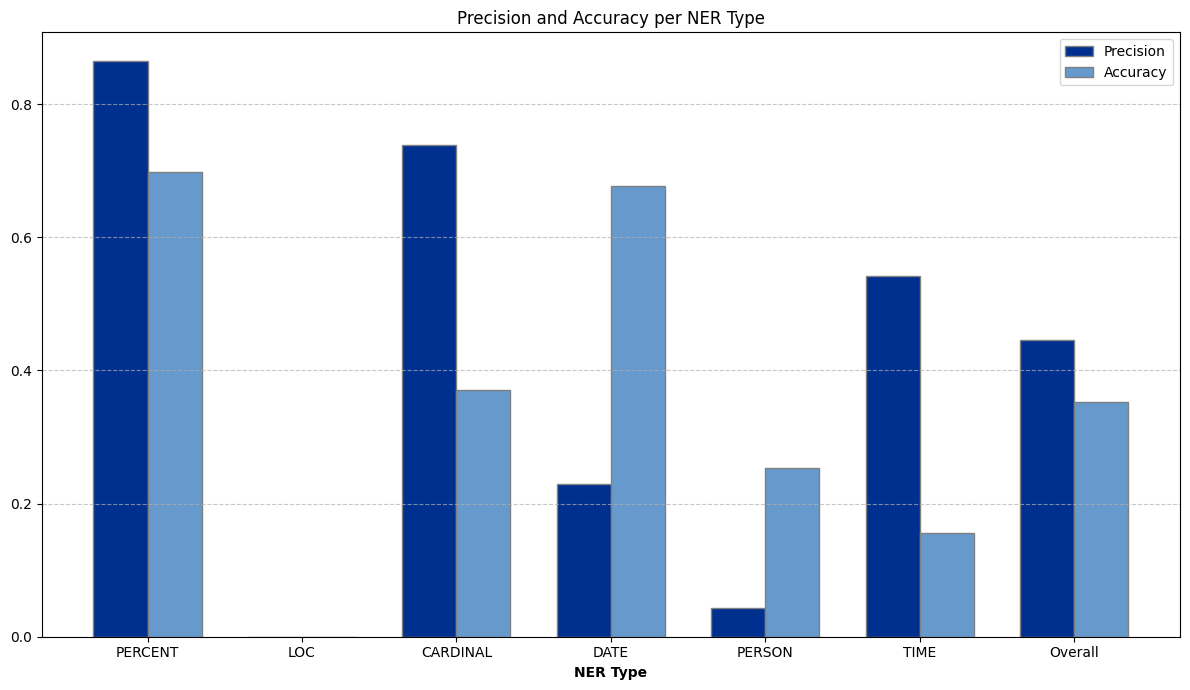

In [26]:
# Convert the precision_per_type dictionary to a DataFrame
df = pd.DataFrame(precision_per_type).T
df.reset_index(inplace=True)
df.rename(columns={'index': 'NER Type', 'precision': 'Precision', 'accuracy': 'Accuracy'}, inplace=True)

# Add overall metrics
df = df.append({'NER Type': 'Overall', 'Precision': overall_precision, 'Accuracy': overall_accuracy}, ignore_index=True)

# Set the figure size
plt.figure(figsize=(12, 7))

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(df))
r2 = [x + bar_width for x in r1]

# Create the bars
plt.bar(r1, df['Precision'], color='#00308F', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, df['Accuracy'], color='#6699CC', width=bar_width, edgecolor='grey', label='Accuracy')

# Add labels to the x-axis
plt.xlabel('NER Type', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(df))], df['NER Type'])

# Add the legend
plt.legend()

# Add the title
plt.title('Precision and Accuracy per NER Type')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


### *Findings*

- In this section, we evaluated the spaCy NER classifier against a manually annotated ground truth of 100 samples from the Argilla medical dataset. 
- We see that the model performs best in identifying percentages, followed by cardinals. This aligns with expectations, as numerical entities like percentages and cardinals are typically more straightforward to detect due to their distinct patterns. 
- However, the classifier shows reduced accuracy in recognizing entities such as locations and persons. 
- These findings support/confirm the inferences we made from the qualitative analysis.

# **PART D - Extending NER Types**  
---
_Extend the standard NER types usingthe NER Annotator and re-run the NER classification as well as its evaluation._

In our dataset, we annotated the following custom MER types using the NER Annotator: 
1. Medical Procedures/Interventions/Examinations & Tests: Actions performed to diagnose, treat, or monitor health conditions.
2. Medical Diagnoses & Clinical Findings: Identified diseases, disorders, or clinical observations.
3. Anatomical Locations & Body Parts: Specific areas or structures within the human body.
4. Medications/Therapeutic Agents: Substances used for treatment or prevention of diseases.
5. Symptoms/Chief Complaints: Patient-reported experiences indicating potential health issues.

In [27]:
# Load the annotations.json dataset
with open("annotations.json", "r") as f:
    data = json.load(f)

# Extract classes and annotations from the dataset
classes = data["classes"]
annotations = data["annotations"]

In [28]:
# Prepare the training data
TRAINING_DATA = []
for entry in annotations:
    if isinstance(entry, list) and len(entry) == 2:
        text = entry[0].strip()
        entities = [(start, end, label) for start, end, label in entry[1]["entities"]]
        TRAINING_DATA.append((text, {"entities": entities}))

# Check if training data is populated
if not TRAINING_DATA:
    raise ValueError("TRAINING_DATA is empty. Please verify the annotations structure.")

# Split the data into training and testing sets
train_data_raw, test_data_raw = train_test_split(TRAINING_DATA, test_size=0.2, random_state=42)

# Load the pre-trained model
nlp = spacy.load("en_core_web_sm")

# Function to clean and validate training data
def validate_training_data(nlp, training_data):
    valid_data = []
    for text, annotations in training_data:
        entities = annotations["entities"]
        cleaned_entities = []
        for start, end, label in entities:
            # Ensure start and end are within the valid range
            if start < 0 or end > len(text) or start >= end:
                continue
            # Remove leading whitespace
            while start < len(text) and text[start].isspace():
                start += 1
            # Remove trailing whitespace
            while end > start and text[end - 1].isspace():
                end -= 1
            # Add the cleaned entity if valid
            if start < end:
                cleaned_entities.append((start, end, label))
        # Create spans, filter out None, and remove overlaps
        doc = nlp.make_doc(text)
        spans = [doc.char_span(start, end, label=label) for start, end, label in cleaned_entities]
        spans = [span for span in spans if span is not None]  # Filter out None spans
        filtered_spans = filter_spans(spans)  # Removes overlapping spans
        valid_entities = [(span.start_char, span.end_char, span.label_) for span in filtered_spans]
        if valid_entities:
            valid_data.append((text, {"entities": valid_entities}))
    return valid_data

# Validate the training and testing data
train_data = validate_training_data(nlp, train_data_raw)
test_data = validate_training_data(nlp, test_data_raw)

In [29]:
# Get the NER component from the pipeline
ner = nlp.get_pipe("ner")

# Add new entity labels to the NER component
for label in classes:
    if label not in ner.labels:
        ner.add_label(label)

# Convert the training data to spaCy Example objects
train_examples = [Example.from_dict(nlp.make_doc(text), annotations) for text, annotations in train_data]

# Disable other pipeline components to train only NER
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    # Resume training (do not reinitialize the model)
    optimizer = nlp.resume_training()

    # Set random seed for reproducibility
    random.seed(42)

    # Training loop
    for epoch in range(30):
        random.shuffle(train_examples)
        losses = {}
        batches = minibatch(train_examples, size=8)
        for batch in batches:
            nlp.update(batch, drop=0.4, losses=losses, sgd=optimizer)
        print(f"Epoch {epoch + 1}, Losses: {losses}")

# Save the fine-tuned model
nlp.to_disk("fine_tuned_model")
print("Fine-tuned model saved.")

Epoch 1, Losses: {'ner': 2714.976176604495}
Epoch 2, Losses: {'ner': 1320.2603016170906}
Epoch 3, Losses: {'ner': 1533.4498580907239}
Epoch 4, Losses: {'ner': 1444.607026911246}
Epoch 5, Losses: {'ner': 1668.4653118409915}
Epoch 6, Losses: {'ner': 1278.2384718826506}
Epoch 7, Losses: {'ner': 1283.504029131158}
Epoch 8, Losses: {'ner': 1168.2420484557515}
Epoch 9, Losses: {'ner': 1247.8149196434533}
Epoch 10, Losses: {'ner': 1262.47586926652}
Epoch 11, Losses: {'ner': 1319.6644658566802}
Epoch 12, Losses: {'ner': 1168.0948333491397}
Epoch 13, Losses: {'ner': 1095.8425552578992}
Epoch 14, Losses: {'ner': 1153.2586308121681}
Epoch 15, Losses: {'ner': 1078.2528759884008}
Epoch 16, Losses: {'ner': 1302.8624592005654}
Epoch 17, Losses: {'ner': 1338.3183155213192}
Epoch 18, Losses: {'ner': 1194.6491986213812}
Epoch 19, Losses: {'ner': 1387.2348235735772}
Epoch 20, Losses: {'ner': 1127.952124813919}
Epoch 21, Losses: {'ner': 1139.530288846995}
Epoch 22, Losses: {'ner': 1235.2459284948418}
Epoc

In [30]:
# Evaluate the model on the test set
test_examples = []
for text, annotations in test_data:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    test_examples.append(example)

# Evaluate and print the results
scorer = nlp.evaluate(test_examples)
print(f"Precision: {scorer['ents_p']:.2f}")
print(f"Recall: {scorer['ents_r']:.2f}")
print(f"F1-score: {scorer['ents_f']:.2f}")


Precision: 0.18
Recall: 0.04
F1-score: 0.06


# **PART E - Investigating LLM-Based NER Classification**  
---
_Investigate using an LLM-based NER classifier._

## **E.1 - Utilizing Chatbots**

In [31]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")
train_data_trunc = dataset['train'].select(range(20))


In [32]:
def query_model(prompt, model, size):
    # Run the Ollama command in the terminal
    result = subprocess.run(
        ["ollama", "run", f"{model}:{size}"],
        input=prompt,
        text=True,
        capture_output=True
    )
    return result.stdout

def process_all_text_entries(data, model, size, csv_writer):
    for idx, item in enumerate(data):
        document_text = item['text']  # Extract the 'text' field from each entry
        print(document_text[:200])
        
        # Updated prompt to extract all NER types
        prompt = f"Please extract all named entities from the following text. For each entity, specify the type (e.g., PERSON, ORGANIZATION, LOCATION, DATE, etc.): {document_text}. Respond with a list of entities and their types."
        response = query_model(prompt=prompt, model=model, size=size)
        
        # Print response for each entry (optional)
        print(f"Response for entry {idx} using {model} {size}:\n{response}\n")
        
        # Write the response to the CSV file
        csv_writer.writerow([model, size, document_text[:200] + '...', response])  # Include only part of the text for brevity


# Create the CSV file and add headers
output_csv_path = "model_responses.csv"
with open(output_csv_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write the header
    csv_writer.writerow(["Model Name", "Model Size", "Text Sample", "Response to Prompt"])

    # Call the function for each model and size configuration
    process_all_text_entries(train_data_trunc, "llama3.2", "3b", csv_writer)
    #process_all_text_entries(train_data, "llama3.1", "8b", csv_writer)

print(f"Responses have been saved to {output_csv_path}")

PREOPERATIVE DIAGNOSIS:,  Iron deficiency anemia.,POSTOPERATIVE DIAGNOSIS:,  Diverticulosis.,PROCEDURE:,  Colonoscopy.,MEDICATIONS: , MAC.,PROCEDURE: , The Olympus pediatric variable colonoscope was i


Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 440: character maps to <undefined>


Response for entry 0 using llama3.2 3b:
Here is the list of extracted named entities along with their types:

1. Diverticulosis (DISEASE)
2. Iron deficiency anemia (DISEASE)
3. MAC (MEDICATION/DRUG)
4. Olympus pediatric variable colonoscope (DEVICE/EQUIPMENT)
5. Cecum (ANATOMY/STRUCTURE)
6. Ileocecal valve (ANATOMY/STRUCTURE)
7. Appendiceal orifice (ANATOMY/STRUCTURE)
8. Sigmoid colon (ANATOMY/STRUCTURE)
9. Polyps (DISEASE)
10. Lesions (DISEASE)
11. Blood (SUBSTANCE)
12. Hemorrhoids (DISEASE)
13. Dr. X (PERSON)

Note: Some entities could potentially be classified under more specific categories, but I have provided the most general and relevant classification for each entity based on the context of the text.



CLINICAL INDICATION:  ,Normal stress test.,PROCEDURES PERFORMED:,1.  Left heart cath.,2.  Selective coronary angiography.,3.  LV gram.,4.  Right femoral arteriogram.,5.  Mynx closure device.,PROCEDURE
Response for entry 1 using llama3.2 3b:
Here is the list of named entities extr

Exception in thread Thread-19 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 200: character maps to <undefined>


Response for entry 6 using llama3.2 3b:
Here is the list of named entities extracted from the text along with their types:

1. **Intrauterine pregnancy** (LOCATION/ EVENT)
2. **Previous cesarean section** (EVENT)
3. **Multiparity** (CONDITION)
4. **Request for permanent sterilization** (REQUEST)
5. **Breach presentation** (EVENT)
6. **Female neonate** (ORGANISM)
7. **Baby** (ORGANISM)
8. **Patient** (PERSON)
9. **Congenital hip problems** (CONDITION)
10. **Third C-section** (PROCEDURE)
11. **Tubal ligation** (PROCEDURE)
12. **Foley to gravity** (DRAINS)
13. **AstraMorph anesthesia** (MEDICATION)
14. **Pfannenstiel skin incision** (PROCEDURE)
15. **Mayo scissors** (INSTRUMENT)
16. **Ochsner clamps** (INSTRUMENT)
17. **Metzenbaum scissors** (INSTRUMENT)
18. **Bladder flap** (ORGAN)
19. **Uterus** (ORGAN)
20. **Amniotic fluid** (SUBSTANCE)
21. **Placenta cord gases** (SUBSTANCE)
22. **Pediatricians** (PROFESSIONAL ORGANIZATION)
23. **Vicryl suture** (MEDICATION)
24. **Cautery** (INSTRUMEN

Exception in thread Thread-29 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 200: character maps to <undefined>


Response for entry 11 using llama3.2 3b:
Here is the list of extracted named entities along with their types:

1. Person:
	* The patient (87-year-old white female)
2. Organization:
	* UTMB Hospitals
3. Location:
	* Terrace Independent Living Center
	* Terrace
4. Date:
	* January 29, 2007
	* April 2004
	* 1981
5. Event:
	* Thanksgiving (2006)
6. Condition/Disease:
	* Depression
	* Hypertension
	* Cataracts
	* Hysterectomy
	* MI (Myocardial Infarction)
	* Osteoporosis
	* Right total knee replacement
	* Diabetes
	* Meningioma
7. Medication:
	* Norvasc
	* Aspirin
	* Lipitor
	* Klonopin
	* Digoxin
	* Lexapro
	* TriCor
	* Lasix
	* Ismo
	* Lidocaine patch
	* Zestril
	* Prinivil
	* Lopressor
	* Starlix
	* Pamelor
	* Polyethylene glycol
	* Potassium chloride
	* Norco
	* Zofran
8. Allergy:
	* Codeine (hallucinations)
9. Family History:
	* None mentioned
10. Social/Developmental History:
	* Married for 40+ years
	* Widowed in 1981
	* Administrative assistant in UTMB Hospitals VP's office
11. Ment

Exception in thread Thread-31 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 224: character maps to <undefined>


Response for entry 12 using llama3.2 3b:
Here is the list of named entities extracted from the text, along with their types:

1. Bunion - ORGANIZATION (in this context, referring to a foot deformity)
2. Charcot-Marie tooth disease - DISEASE
3. ABCD General Hospital - ORGANIZATION (hospital)
4. Department of Anesthesia - ORGANIZATION (department within the hospital)
5. Webril - PRODUCT (medical supply)
6. Lidocaine - PRODUCT (medication)
7. Marcaine - PRODUCT (medication)
8. Mayo block type fashion - TECHNIQUE (surgical method)
9. Esmarch bandage - PRODUCT (medical supply)
10. Pneumatic ankle tourniquet - PRODUCT (medical device)
11. Stockinette - PRODUCT (medical supply)
12. Wet and dry sponge - PRODUCT (medical supply)
13. #15 blade - TOOL (surgical instrument)
14. Extensor digitorum longus tendon - ORGAN
15. Capsule - ORGAN (in this context, referring to the fibrous tissue surrounding a joint)
16. First metatarsal phalangeal - LOCATION (specifically, the first bone in the foot's toes

Exception in thread Thread-43 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 200: character maps to <undefined>


Response for entry 18 using llama3.2 3b:
Here is the list of named entities extracted from the text along with their types:

1. Person - "This is a 29-year-old African-American male"
2. Location - None
3. Organization - None
4. Date - Not specified, but implied as "today" and "last night"
5. Event - "being shot in the back" (past event)
6. Substance - Blood
7. Condition - "bloody bump on penis", "penile mass"
8. Medical Procedure - Excision of a bullet after being shot in the back, surgery for excision of a penile mass
9. Medication - None
10. Allergen - None
11. Behavior/Habit - "trying to get some" (referring to engaging in sexual intercourse)
12. Substance/Drug - Tobacco, alcohol
13. Organ/Body Part - Penis
14. System - Genitourinary system
15. Diagnosis - Penile mass

Note that some of these entities may be implicit or inferred from the text rather than being explicitly stated.



PROCEDURE IN DETAIL:,  After appropriate operative consent was obtained, the patient was brought supin

### *Findings*
- It was relatively simple to run LLama3.2 locally
- Because Llama is designed to take an input prompt and generate text in response, it is suitable for conversational AI, interactive querying, and generating outputs based on a range of instructions
- This allowed the model to identify NER that goes beyond SpaCy's capabilities, identifying medicines, body parts, medical procedures, etc.
- However, each output was in different formats. For ideal results, careful prompt engineering and post processing would be necessary.

## **E.2 - Applying NER Models**

In [33]:
# Load the model and tokenizer
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

### Possible models to choose from
### Universal-NER/UniNER-7B-type-sup
### emilyalsentzer/Bio_ClinicalBERT
### bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Create the NER pipeline
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer) # runs the specific model in NER mode

# Example text
text = "John Doe was diagnosed with Type 2 Diabetes on 2024-11-10."

# Perform NER
entities = nlp_ner(text)

# Print out the recognized entities
for ent in entities:
    print(f"Entity: {ent['word']}, Label: {ent['entity']}, Score: {ent['score']:.4f}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Entity: j, Label: LABEL_0, Score: 0.5789
Entity: ##oh, Label: LABEL_0, Score: 0.5478
Entity: ##n, Label: LABEL_0, Score: 0.6181
Entity: do, Label: LABEL_0, Score: 0.6490
Entity: ##e, Label: LABEL_0, Score: 0.5899
Entity: was, Label: LABEL_0, Score: 0.5218
Entity: diagnosed, Label: LABEL_0, Score: 0.5584
Entity: with, Label: LABEL_0, Score: 0.5795
Entity: type, Label: LABEL_0, Score: 0.6191
Entity: 2, Label: LABEL_0, Score: 0.6182
Entity: diabetes, Label: LABEL_0, Score: 0.6068
Entity: on, Label: LABEL_0, Score: 0.5671
Entity: 202, Label: LABEL_0, Score: 0.6095
Entity: ##4, Label: LABEL_0, Score: 0.5017
Entity: -, Label: LABEL_0, Score: 0.5182
Entity: 11, Label: LABEL_0, Score: 0.5618
Entity: -, Label: LABEL_0, Score: 0.5305
Entity: 10, Label: LABEL_0, Score: 0.5519
Entity: ., Label: LABEL_0, Score: 0.5661


### *Findings*

- Loading the model took the longest in this process
- This model was trained for the task of extracting NER from text, and was on the clinical NER leaderboard on Hugging Face
- The outputs on this test statement show that the entities that were extracted are not specific to the medical field, meaning that fine tuning would be needed to use this on our data

_Advantages of LLMs for NER_

- LLMs, such as BERT or GPT, excel at understanding medical context, enabling them to accurately identify rare diseases, uncommon symptoms, or jargon that traditional NER models might miss. 
- Their ability to capture complex relationships, like drug-disease interactions or symptom-disease links, makes them particularly effective for medical applications. 
- They also benefit from transfer learning, as they are pre-trained on large datasets, and can be fine-tuned with smaller domain-specific datasets to improve performance in specific medical fields. 
- They are scalable and versatile, capable of adapting to various medical domains (e.g., oncology, psychiatry) and handling multilingual medical texts. 
- Additionally, they manage ambiguous or variable terminology well, disambiguating terms with multiple meanings (e.g., "stroke") and recognizing synonyms or different phrasings (e.g., "heart attack" vs. "myocardial infarction").

_Disadvantages of LLMs for NER_
- Despite their strengths, LLMs are resource-intensive, requiring substantial computational power, memory, and storage for training and inference, which may limit their practicality in low-resource settings. 
- Fine-tuning on medical data demands high-quality, annotated datasets that are expensive and time-consuming to create, and insufficiently diverse training data can lead to biases and poor generalization. 
- LLMs also lack transparency, making it difficult to understand or fix errors, and they are sensitive to noisy data, such as misspellings or informal notes in medical records. 
- Ethical and privacy concerns are significant, as improper handling of medical data could compromise patient confidentiality. 
- Errors in entity recognition, such as misclassifying a diagnosis or treatment, could have serious consequences in clinical contexts.

# **PART F - Use Cases of NER**  
---
_Describe how NER type information could help in other NLP use cases._

NER type information can help with enhancing downstream tasks, for example:

1. Document Classification:  
    -  Identifying medical entities (e.g., diseases, drugs, procedures) allows the system to understand document themes and assign categories more accurately.
    - For example, we could use this to classify medical records into categories such as diagnosis, treatment, or follow-up notes.

2. Information Retrieval:
    - Extracting entities like drug names or disease names can improve the precision of search queries, ensuring more relevant results.
    - For example, this could be used for retrieving research papers or patient cases related to specific diseases or treatments.

3. Question Answering:
    - Recognizing entities like drug names and symptoms helps the system match the query to appropriate answers in medical literature.
    - For example, such an arrangement could answer medical queries, like "What are the side effects of Drug X?"

4. Summarization:
    - Extracting key entities such as diagnoses and treatments can help to create more concise, entity-rich summaries.
    - For example, upon a patient's visit to the Emergency Department, this approach could be used to generate summaries of the patient's visit to help with their understanding.

